In [5]:
import numpy as np
import matplotlib.pyplot as plt
from math import asin,pi, sqrt
import matplotlib.patches as patches
import matplotlib
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator, LogLocator)
from matplotlib.colors import DivergingNorm



In [6]:
clight    = 2.99792458e10 # en cm
#Msun      = 1.989e33

## PARAMETERS ##
vmax      = 0.9*clight
vmin_dyn  = 0.08*clight
vmax_wind = 0.08*clight
vmin      = 0.025*clight
day       = 3600*24 # time equal to one day 
nb_cell   = 10 # numbers of cells in one direction
phi       = pi/4   # ouverture angulaire de 45° % a l'axe de la fusion
alpha1    = 3
alpha2    = 6



## REF for dnsity ##
#Mej_ref  = 0.03 * Msun
#vref_dyn = 0.05 * clight
#vtr      = 0.3 * clight
#rho_ref   = Mej_ref / 4. / np.pi / (vref_dyn * t)**3 / np.log(vtr/vref_dyn) 

#print(step/10**13,x_max,t,v)

/Users/linaissa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: No contour levels were found within the data range.


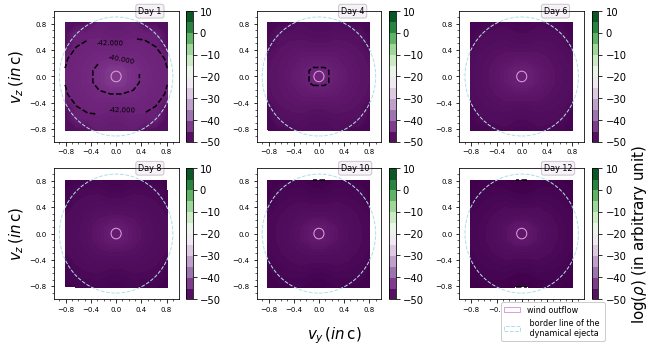

In [7]:

def density(r,alpha):
    return  A*r**(-alpha)     # on prend A = 1

EPOCH = [1, 4, 6, 8, 10, 12]
for (i, epoch)  in enumerate(EPOCH):
    t    = epoch * day 
    R    = t*vmax     #le rayon de la grille
    step = 2*R/(nb_cell) 
    x = np.zeros(nb_cell)
    for a in range(nb_cell):
        x[a] = R - a*step

    y = np.zeros(nb_cell)
    for a in range(nb_cell):
        y[a] = R - a*step
    
    z = np.zeros(nb_cell)
    for a in range(nb_cell):
        z[a] = R - a*step
    
    X = []
    Y = []
    Z = []
    Ye_tot = []
    dens_tot = []
    dataR = []
    with open("grid_input_opang45.txt", "w+", encoding = 'utf-8') as model:
        model.write(f"{nb_cell} {R:e} {t} \n")
        for l in x:
            for m in y:
                for n in z: 
                    r = sqrt((l-step/2)**2 + (m-step/2)**2 + (n-step/2)**2)      
                    if r>R or r<(vmin*t):               #outside the sphere 
                        A = 1.
                        dens  = density(r,alpha1)
                        gamma = 0.4
                    else:
                        A = 10**50 
                        if (vmin*t)<r<(vmin_dyn*t):  #in the wind outflow
                            dens  = density(r,alpha1)
                            gamma = 0.25
                        #Mej_wind.append(dens*step**3)
                        else:                         #in the dynamical outflow
                            theta = asin((n-step/2)/r)
                            dens = density(r,alpha2) * np.sin(np.pi/2-theta)**2 
                        #Mej_dyn.append((dens*step**3))
                            if abs(theta) < phi:     # red ejecta 
                                gamma = 0.2
                            else:
                                gamma = 0.4 
                    Ye_tot.append(gamma)
                    dens_tot.append(dens)
                    X.append(l-step/2)
                    Y.append(m-step/2)
                    Z.append(n-step/2)
                    dataR.append(r)
                    model.write(f'{(l-step/2):e} {(m-step/2):e} {(n-step/2):e} {dens:e} {gamma}\n')
                    
    Y_grid, Z_grid = np.meshgrid(np.sort(np.unique(Y)),np.sort(np.unique((Z))))

    size1 = np.shape(Y_grid)[0]
    size2 = np.shape(Z_grid)[0]
    Gamma  = np.full(np.shape(Y_grid), 0.5)
    Rho    = np.full(np.shape(Y_grid), 0.5)
    for index1, yl, zl in zip(range(size1), Y_grid, Z_grid):
        for index2, valY, valZ in zip(range(size2), yl, zl):
            whereY       = Y == valY
            whereZ       = Z == valZ
            whereY_and_Z = np.logical_and(whereY,whereZ)
            position_list = np.array(np.where(whereY_and_Z))[0] # liste des nb_cell positions où le couple (Y,Z) est dégénré pour chaque valeur de X 
            index = int((nb_cell/2)-1) # choix de index guidé par la valeur souhaitée à X 
            position = position_list[index]
        #print( X[position])
            valGamma = Ye_tot[position]
            valRho   = dens_tot[position]
            Gamma[index1,index2] = valGamma
            Rho[index1,index2]   = valRho 
    v_y = Y_grid/(t*clight)
    v_z = Z_grid *1/t *1/clight
    v_ejecta_min = vmin *1/clight
    v_wind_max   = vmin_dyn * 1/clight
    v_ejecta_max = vmax /clight
    
    numplot      = 231 + i
    
    ax = plt.subplot(numplot)
    
    plt.xticks(np.arange(-0.8,0.9,0.4))
    plt.yticks(np.arange(-0.8,0.9,0.4))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.tick_params(axis='both', labelsize = 7)
    a2 = patches.Ellipse((0,0), v_wind_max*2,v_wind_max*2, linewidth = 1, alpha = 1, label= 'wind outflow',edgecolor="plum", fill = False)#, facecolor='darkgreen', fill = True)
    plt.gca().add_patch(a2)
    a3 = patches.Ellipse((0,0), v_ejecta_max*2,v_ejecta_max*2, edgecolor="powderblue", facecolor='None', linestyle = '--', linewidth=1,label=" border line of the \n dynamical ejecta")
    plt.gca().add_patch(a3)
    
    cmin = -50.
    cmax = 10.
    #norm = matplotlib.colors.Normalize(vmin = cmin, vmax = cmax)
    divnorm = DivergingNorm(vmin = cmin, vmax = cmax, vcenter = 0)
    cmap = matplotlib.cm.PRGn
    
    levels = np.arange(cmin, cmax, 0.5)

    dt = ax.contourf(v_y, v_z,np.log10(Rho), levels, norm = divnorm, cmap=matplotlib.cm.get_cmap(cmap,len(levels)-1))
    m = plt.cm.ScalarMappable(cmap= cmap)
    m.set_array(np.log10(Rho))
    m.set_clim(cmin,cmax)
    
    cont = plt.contour(v_y, v_z, np.log10(Rho), levels = [-42, -40], colors='black')
    cont.clabel(fontsize=7)
    #axes = plt.axes(list(np.arange(vmin, vmax, 5)))
    if i == 0 or i == 3:
        ax.set_ylabel(r'$v_{z} \,( in \, \rm{c})$', size=15)

    col = plt.colorbar(m, boundaries = np.linspace(cmin,cmax, 13)) #,cax = plt.axes([-40, -35, -30, -25, -20, -15, -10,  -5,   0]))
    col.ax.tick_params(labelsize=10)

    if i == len(EPOCH) -1:
        col.set_label(r'$\log(\rho)$ (in arbitrary unit)', size=15)#, x = 3, y = 1.5)

    ax.text(0.35, 0.95, 'Day {}'.format(epoch), bbox=dict(facecolor='thistle', alpha=0.2, boxstyle='round'), size=8)

#ax.Axes.set_aspect('equal')
ax.xaxis.set_label_coords(-1,-0.2)
ax.set_xlabel(r'$v_{y} \,( in \, \rm{c})$', size=15)
plt.subplots_adjust(left = -0.1, right = 1.2, bottom=0,top=1, wspace = 0.3, hspace= 0.2)

plt.legend( loc= 4, bbox_to_anchor=(1.2,-0.35), fontsize= 8,framealpha = 1)#,  shadow = True)
plt.savefig("map_density_times.pdf", bbox_inches='tight')



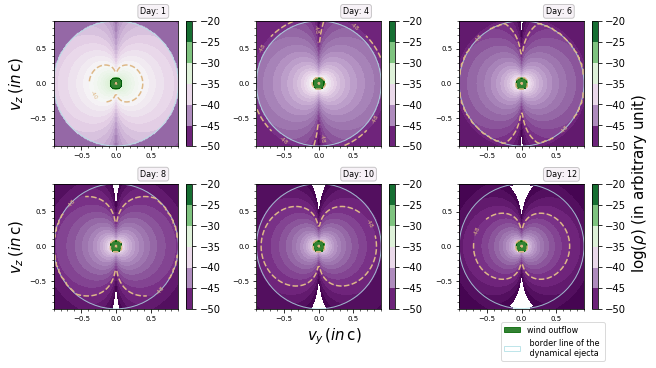

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from math import asin,pi, sqrt
import matplotlib.patches as patches
import matplotlib
from matplotlib.colors import DivergingNorm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator, LogLocator)

clight    = 2.99792458e10 # en cm
#Msun      = 1.989e33

## PARAMETERS ##
vmax      = 0.9*clight
vmin_dyn  = 0.08*clight
vmax_wind = 0.08*clight
vmin      = 0.025*clight
day       = 3600*24 # time equal to one day 
nb_cell   = 100 # numbers of cells in one direction
phi       = pi/4   # ouverture angulaire de 45° % a l'axe de la fusion
alpha1    = 3
alpha2    = 6

def density(r,alpha):
    return  A*r**(-alpha)     # on prend A = 1

data_file  = ['mesh_grid_t1_N100.txt', 'mesh_grid_t4_N100.txt', 'mesh_grid_t6_N100.txt', 'mesh_grid_t8_N100.txt', 'mesh_grid_t10_N100.txt', 'mesh_grid_t12_N100.txt']


#for i in range(size): 
#    l = size * i 
#    j = i
#    while l < (i+1)*size and j < size:
#        Y_grid[i,j] = Y[l]
#        Z_grid[i,j] = Z[l]
#       Rho[i,j] = ValRho[l]
#        Gamma[i,j] = ValGamma[l]
#        l+=1
#       j+=1


EPOCH = [1, 4, 6, 8, 10, 12]
for (i, epoch)  in enumerate(EPOCH):
    
    data  = data_file[i]
    Y     = np.genfromtxt(fname = data, skip_header = 1, dtype ='float', usecols = (0) )
    Z     = np.genfromtxt(fname = data,skip_header = 1, dtype ='float', usecols = (1) )
    ValGamma=  np.genfromtxt(fname = data, skip_header = 1,dtype ='float', usecols = (2) )
    ValRho  =  np.genfromtxt(fname = data,skip_header = 1, dtype ='float', usecols = (3) )
    INDEX1  = np.genfromtxt(fname = data, skip_header = 1,dtype ='int', usecols = (4) )
    INDEX2  = np.genfromtxt(fname = data,skip_header = 1, dtype ='int', usecols = (5) )



    Y_grid = np.zeros((nb_cell, nb_cell))
    Z_grid = np.zeros((nb_cell, nb_cell))
    Rho    = np.zeros((nb_cell, nb_cell))
    Gamma  = np.zeros((nb_cell, nb_cell))
     
    
    for (index1,index2, valy, valz, valRho, valGamma)  in zip(INDEX1, INDEX2, Y, Z, ValRho, ValGamma): 
        
        Y_grid[index1, index2] = valy
        Z_grid[index1, index2] = valz
        Rho[index1, index2]    = valRho #*10000
        Gamma[index1,index2]   = valGamma
    
    t    = epoch * day 
    R    = t*vmax     #le rayon de la grille
    step = 2*R/(nb_cell) 
    
    v_y = Y_grid/(t*clight)
    v_z = Z_grid *1/t *1/clight
    v_ejecta_min = vmin *1/clight
    v_wind_max   = vmin_dyn * 1/clight
    v_ejecta_max = vmax /clight
    
    numplot      = 231 + i 
    
    ax = plt.subplot(numplot)
    
    plt.xticks(np.arange(-1,1.1,0.5))
    plt.yticks(np.arange(-1,1.1,0.5))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.set_xlim([-0.9,0.9])
    ax.set_ylim([-0.9,0.9])
    ax.tick_params(axis='both', labelsize = 7)

    cmin = -50.
    cmax = -20.
    norm = matplotlib.colors.Normalize(vmin = cmin, vmax = cmax)
    divnorm = DivergingNorm(vmin = cmin, vmax = cmax, vcenter = -40)
    cmap = matplotlib.cm.PRGn
    
    levels = np.arange(cmin, cmax, 0.5)
    
    dt = ax.contourf(v_y, v_z,(np.log10(Rho)), levels, norm = divnorm,  cmap= matplotlib.cm.get_cmap(cmap, len(levels)-1))
    m = plt.cm.ScalarMappable(cmap= cmap)
    m.set_array(np.log10(Rho))
    m.set_clim(cmin,cmax)                                                                            

    


    if i == 0 or i == 3: 
        ax.set_ylabel(r'$v_{z} \,( in \, \rm{c})$', size=15)
    col = plt.colorbar(m, boundaries = np.linspace(cmin,cmax, 7)) 
    col.ax.tick_params(labelsize=10)
    if i == len(EPOCH) -1:
         col.set_label(r'$\log(\rho)$ (in arbitrary unit)', size=15, x = 3, y = 1)
    
    cont = plt.contour(v_y, v_z, np.log10(Rho), levels = [-48, -40], colors='burlywood')
    cont.clabel(fontsize=6,fmt='%d', colors='burlywood' )
   #
    a2 = patches.Ellipse((0,0), v_wind_max*2,v_wind_max*2, fill = True,linewidth=1,alpha=0.8,label="wind outflow", edgecolor = 'darkgreen',  linestyle = '-', facecolor='darkgreen' )#edgecolor="darkgreen", , fill = True,linewidth=3,alpha=1,label="wind outflow")
    plt.gca().add_patch(a2)
    a3 = patches.Ellipse((0,0), v_ejecta_max*2,v_ejecta_max*2, edgecolor="powderblue", facecolor='None', linestyle = '-', linewidth=1, alpha=0.8,label=" border line of the \n dynamical ejecta")
    plt.gca().add_patch(a3)


        
    ax.text(0.35, 1., f'Day: {epoch}', bbox=dict(facecolor='thistle', alpha=0.2, boxstyle='round'), size=8)
    
ax.axes.set_aspect('equal')


#ax.set_title('Density map at t= 1 day')
#ax.xaxis.set_label_coords(-1,-0.2)
ax.set_xlabel(r'$v_{y} \,( in \, \rm{c})$', size=15, x= -1, y=-0.45 )
plt.subplots_adjust(left = -0.1, right = 1.2, bottom=0,top=1, wspace = 0.3, hspace= 0.3)
#plt.title("Density map at 1 day after the merger",  fontsize= 10, bbox_to_anchor=(1.2,-0.45) )
plt.legend( fontsize= 8, framealpha = 0.7, loc = 4, bbox_to_anchor=(1.2,-0.45))#,  shadow = True)
plt.savefig("mapDensity_N100.pdf", bbox_inches='tight')

# Defining the cells

In [56]:
np.max(v_z)

0.8820000000007052

In [4]:
list(np.arange(-40,5, 5))

[-40, -35, -30, -25, -20, -15, -10, -5, 0]

In [41]:
## Sanity check ##
print(nb_cell/2)
print(np.unique(X))
print(np.min(den_tot))
print(np.shape(Y_grid))

[-2.28456243e+15 -2.19131498e+15 -2.09806754e+15 -2.00482009e+15
 -1.91157265e+15 -1.81832520e+15 -1.72507775e+15 -1.63183031e+15
 -1.53858286e+15 -1.44533542e+15 -1.35208797e+15 -1.25884052e+15
 -1.16559308e+15 -1.07234563e+15 -9.79098184e+14 -8.85850738e+14
 -7.92603292e+14 -6.99355846e+14 -6.06108400e+14 -5.12860954e+14
 -4.19613508e+14 -3.26366061e+14 -2.33118615e+14 -1.39871169e+14
 -4.66237231e+13  4.66237231e+13  1.39871169e+14  2.33118615e+14
  3.26366061e+14  4.19613508e+14  5.12860954e+14  6.06108400e+14
  6.99355846e+14  7.92603292e+14  8.85850738e+14  9.79098184e+14
  1.07234563e+15  1.16559308e+15  1.25884052e+15  1.35208797e+15
  1.44533542e+15  1.53858286e+15  1.63183031e+15  1.72507775e+15
  1.81832520e+15  1.91157265e+15  2.00482009e+15  2.09806754e+15
  2.19131498e+15  2.28456243e+15]


Problème de dégénérescence.
Chaque valeur de Y/Z est répétée un nombre 2 x #cell et un couple de valeurs de (Y,Z) est répété #cell fois. 
Lorsque l'on projette une grille tridimensionnelle sur une grille à deux dimensions => réduction de données.
Il faut alors penser à fixer une valeur de X = (on prend X proche de 0 ici) et alors on obtient un plan (Y,Z) pour une valeur donnée de X. 

In [31]:
size =10
Y = np.zeros((10,10))

In [32]:
Y

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

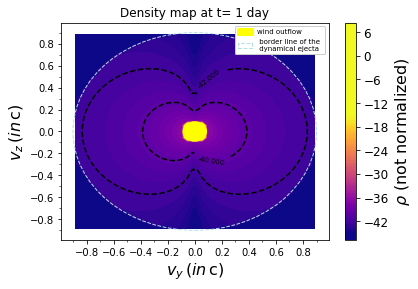

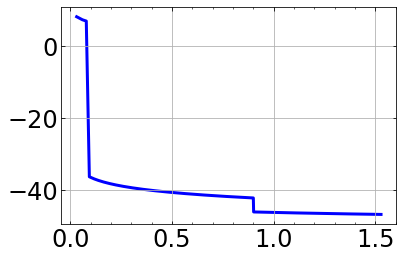

In [89]:
AX, LW = asManyPlots(111,dataR, dataDens, plotFlag = True, linestyle='-', markerSize =0, linewidth = 3) #color =['red'])
AX.xaxis.set_minor_locator(MultipleLocator(0.1))

In [ ]:
dataR

In [ ]:
x1 = []
x2 = []
rho =[]
fract_electron =[]
for i in range(len(x)): 
    if x[i] == 7.770616e+12:
        x1.append(y[i])
        x2.append(z[i])
        rho.append(dens[i])
        fract_electron.append(gamma[i]) 

In [ ]:
print(len(x1), len(x2))

In [ ]:
Y, Z = np.meshgrid(np.sort(np.unique(x1)),np.sort(x2))
Gamma = np.copy(Y)

size1 = np.shape(Y)[0]
size2 = np.shape(Z)[0]

In [ ]:
for index1, yl, zl in zip(range(size1), Y, Z):
    for index2, valY, valZ in zip(range(size2), yl, zl):
        whereY       = x1 == valY
        whereZ       = x2 == valZ
        whereY_and_Z = np.logical_and(whereY,whereZ)
        position             = np.array(np.where(whereY_and_Z))[0][0]
        valF                 = fract_electron[position]
        Gamma[index1,index2] = valF
       

In [ ]:

ax = plt.subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', direction='in', labelsize=26)


dt = ax.contourf(Y, Z, Gamma, 200, cmap='coolwarm')
col = plt.colorbar(dt)

col.set_label(r'$\gamma_e$', size=26)
ax.set_xlabel(r'$y, \rm{cm}$', size=26)
ax.set_ylabel(r'$z, \rm{cm}$', size=26)
col.ax.tick_params(labelsize=22)
cont = plt.contour(Y, Z, Gamma, levels=[0.3,0.5,1], colors='black', linestyle="--")
cont.clabel(fontsize=10)
plt.savefig("ejecta_diagram.pdf", bbox_inches='tight')

In [40]:
x = np.linspace(-5,5, 50)
def demi_cercle(x):
    y=[]
    for elt in x:
        a = sqrt(5**2 - elt**2)
        y.append(a)
    return y

def demi_cercle2(x):
    y=[]
    for elt in x:
        a = -sqrt(5**2 - elt**2)
        y.append(a)
    return y



y1 = demi_cercle(x) 
y2 = demi_cercle2(x)

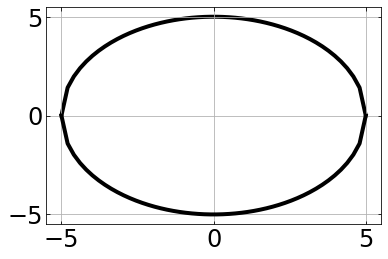

In [43]:
ax, lw = asManyPlots(111, [x,x], [y1,y2], plotFlag=[True, True], markerSize = [0,0], linestyle= ['-','-'], color=['black', 'black'], linewidth=4)

In [136]:
def make_circle(r):
    t = np.arange(0, np.pi * 2.0, 0.01)
    #t = t.reshape((len(t), 1))
    x = r * np.cos(t)
    y = r * np.sin(t)
    return x,y
def make_circle2(r):
    t = np.arange(-np.pi/2, np.pi/2, 0.01)
    #t = t.reshape((len(t), 1))
    x = r * np.cos(t)
    y = r * np.sin(t)
    return x,y
x_circle,y_circle = make_circle(1)
x_circle2,y_circle2 = make_circle2(1)

In [163]:
x_plus = np.arange(0.0, 1, 0.01)
x_neg = np.arange(-1, 0.0, 0.01)
def triangle1(phi,x):
    y = np.sin(phi)*x
    return y
def triangle2(phi,x):
    y = - np.sin(phi)*x
    return y

In [164]:

a = int((len(x_circle)+1)/2)
#x  =  x_circle[:a]

#y  =  y_circle
y1 = triangle1(np.pi/6,x_plus)
y2 = triangle2(np.pi/6,x_plus)
y3 = triangle1(np.pi/6,x_neg)
y4 = triangle2(np.pi/6,x_neg)

In [2]:
def make_circle(r):
    t = np.arange(0, np.pi/6, 0.01)
    #t = t.reshape((len(t), 1))
    x = r * np.cos(t)
    y = r * np.sin(t)
    return x,y

In [3]:
vout_dyn = 0.9
ax_ratio_dyn=1
open_angle = 45
vmax_wind = 0.08
vmin      = 0.025
x_arc, y_arc = make_circle(0.1)

x = np.arange(-0.9, 1, 0.1)
y =np.zeros(len(x))
print(y)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


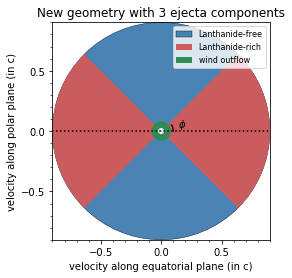

In [6]:
a = patches.Ellipse((0,0), vout_dyn*2,vout_dyn*2*ax_ratio_dyn,facecolor="steelblue",edgecolor="black", linewidth=0.4,zorder=1,alpha=5,label="Lanthanide-free")
plt.gca().add_patch(a)
a=patches.Wedge(0,(vout_dyn,vout_dyn*ax_ratio_dyn),-open_angle,open_angle,zorder=2,facecolor="indianred",alpha=5,edgecolor=None, label="Lanthanide-rich")
plt.gca().add_patch(a)
a=patches.Wedge(0,(-vout_dyn,-vout_dyn*ax_ratio_dyn),-open_angle,open_angle,zorder=2,facecolor="indianred",alpha=5,edgecolor=None)
plt.gca().add_patch(a)
a = patches.Ellipse((0,0), vmax_wind*2,vmax_wind*2*ax_ratio_dyn,facecolor="seagreen",edgecolor=None, linewidth=0,zorder=1,alpha=5,label="wind outflow")
plt.gca().add_patch(a)
a=patches.Wedge(0,(vmax_wind,vmax_wind*ax_ratio_dyn),-open_angle,open_angle,zorder=2,facecolor="seagreen",alpha=5)
plt.gca().add_patch(a)
a=patches.Wedge(0,(-vmax_wind,-vmax_wind*ax_ratio_dyn),-open_angle,open_angle,zorder=2,facecolor="seagreen",alpha=5)
plt.gca().add_patch(a)

a = patches.Ellipse((0,0), vmin*2,vmin*2*ax_ratio_dyn,facecolor="ghostwhite",edgecolor=None, linewidth=0,zorder=1,alpha=5)
plt.gca().add_patch(a)

a=patches.Wedge(0,(vmin,vmin*ax_ratio_dyn),-open_angle,open_angle,zorder=2,facecolor="ghostwhite",alpha=5)
plt.gca().add_patch(a)
a=patches.Wedge(0,(-vmin,-vmin*ax_ratio_dyn),-open_angle,open_angle,zorder=2,facecolor="ghostwhite",alpha=5)
plt.gca().add_patch(a)
plt.plot(x,y, color='black', linestyle='dotted')

plt.plot(x_arc, y_arc, color ='black', alpha = 0.8)

plt.gca().text(0.14, 0.035, r'$\phi$')



plt.title('New geometry with 3 ejecta components')
plt.gca().set_xlabel('velocity along equatorial plane (in c)')
plt.gca().set_ylabel('velocity along polar plane (in c)')
plt.gca().set_aspect(1)
plt.xticks(np.arange(-1,1.1,0.5))
plt.yticks(np.arange(-1,1.1,0.5))
plt.xlim(-0.9,0.9)
plt.ylim(-0.9,0.9)
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.1))
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.1))
plt.legend(fontsize=8)
plt.savefig("model_ejecta_3.pdf", bbox_inches='tight')

In [ ]:
plt.plot(x_circle,y_circle)


#plt.plot(x, y1)
#plt.plot(x, y2)


#plt.fill_between(x_plus, y1, y2, facecolor='firebrick')
#plt.fill_between(x_neg, y3, y4, facecolor='firebrick')
plt.fill_between(x_plus+x_neg, y1, y_circle2, where=(y_circle2.all())>(y1.all()), facecolor='blue')

False


In [139]:
np.shape(y_circle2)

(315,)